# **THOT calibration**

_by Felix Eickemeyer_

Calibration of raw data.

In [17]:
import re
import os
import sys
from thot import ThotProject
from os import getcwd, listdir
import matplotlib.pyplot as plt

from FTE_analysis_libraries import General as gen
from FTE_analysis_libraries import PLQY as lqy
from FTE_analysis_libraries import Spectrum as spc

import pkg_resources
system_dir = pkg_resources.resource_filename('FTE_analysis_libraries', 'System_data')
cal_lamp_dir = pkg_resources.resource_filename('FTE_analysis_libraries', 'System_data/Calibration_lamp_spectra')

In [2]:
# Initializes Thot project
db = ThotProject( dev_root = r'PLQY_results\PLQY' )
#db = ThotProject( dev_root = r'PL' )

In [3]:
#File extension for raw data
file_ext = 'csv'
#file_ext = 'asc'

# Gigahertz calibration lamp
lamp_spec_FN = 'caldata-BN-LH250-V01_sn51102-LH250_snL2229-200805.txt'
hole_diameter = 3e-3 #m

In [4]:
# Load lamp calibration file
lampspec_irr = spc.PEL_spectrum.load(cal_lamp_dir, lamp_spec_FN, header = 1, delimiter = '\t', 
                             quants = dict(x = 'Wavelength', y = 'Spectral irradiance'), units = dict(x = 'nm', y = 'W/[m2 nm]'))

# lampspec = lamp_calib * 1 # change for absolute calibration taking into account excitation port aperture of integrating sphere
#lampspec = lampspec_irr.irradiance_to_photonflux(factor = 1e-6/1e-4) # This factor is used for the OceanOptics calibration lamp HL-3 plus
lampspec = lampspec_irr.irradiance_to_photonflux()
# plot_first_n_lines(cal_lamp_dir, lamp_spec_FN, n=20)
# lampspec_graph = lampspec.plot(yscale = 'log', return_fig = True, show_plot = ( False and db.dev_mode() ))
# lqy.add_graph(db, 'lampspec.png', lampspec_graph)

In [5]:
# Load measured calibration spectra

rawcalib = db.find_assets({'type' : 'raw calibration'})
#print(dir(rawcalib[1]))
#print(rawcalib[3].file)
#print(rawcalib[1].metadata)
sa = []
for i, asset in enumerate(rawcalib):
    fp = asset.file
    # print(fp)
    fn = os.path.basename(fp)
    # print(fn)
    directory = os.path.dirname(fp) # required for long paths
    # print(directory)
    acc = asset.metadata['acc']
    int_s = asset.metadata['int_s']
    calib = spc.PEL_spectrum.load(directory, fn, quants=dict(x = 'Wavelength', y = 'Intensity'), units=dict(x = 'nm', y = 'cps'))
    calib.y = calib.y / (int_s * acc)
    sa.append(calib)
calib = spc.PEL_spectra(sa)
calib.names_to_label('.' + file_ext)
# Make sure that no data value is < min (especially not 0 or negative)
calib.all_values_greater_min(min = 1e-1)

# calibspec_graph = calib.plot(yscale = 'log', figsize = (20,20), return_fig = True, show_plot = ( True and db.dev_mode() ))
# lqy.add_graph(db, 'calibration_spectra.png', calibspec_graph)

In [6]:
# Calculate calibration function. This function is multiplied with all cps data to yield photon flux
calibfn = spc.PEL_spectra.calc_calfn(calib, lampspec)
calibfn.names_to_label('.csv')

#  calibfn_graph = calibfn.plot(yscale = 'log', showindex = True, figsize = (20,20), return_fig = True, show_plot = ( True and db.dev_mode() ))
# lqy.add_graph(db, 'calibration_function.png', calibfn_graph)

In [7]:
# Plot single calibration function
do_this_step1 = False
if do_this_step1:
    idx = 3
    #cal_lamp_Andor.sa[idx].plot(yscale = 'linear')
    calibfn.sa[idx].plot(yscale = 'log', bottom = 8e8, top = 10e10)

In [8]:
# Savgol filter for selected calibration function (700 LP free space)
do_this_step2 = False
if do_this_step2:
    idx = 3
    calibfn_old = calibfn.sa[idx]
    calibfn_new = calibfn_old.savgol(n1 = 11, n2 = 1)
    both = spectra([calibfn_old, calibfn_new])
    both.label(['original', 'savgol'])
    both.plot(yscale = 'log', bottom = 8e8, top = 2e9, title = calibfn.sa[idx].name)
    take_over_calib_new = True
    if take_over_calib_new:
        calibfn.sa[idx] = calibfn_new

In [9]:
# Load all PL raw spectra

rawsamples = db.find_assets({'type' : 'raw PL spectrum'})
#print(rawsamples)
#print(rawsamples[1].file)
#print(rawsamples[1].metadata)
sa = []
for i, asset in enumerate(rawsamples):
    fp = asset.file
    fn = os.path.basename(fp)
    directory = os.path.dirname(fp)
    acc = asset.metadata['acc']
    int_s = asset.metadata['int_s']
    rawPLspectrum = spc.PEL_spectrum.load(directory, fn, quants = dict(x = 'Wavelength', y = 'Intensity'), units = dict(x = 'nm', y = 'cps'))
    rawPLspectrum.y = rawPLspectrum.y / (int_s * acc)
    sa.append(rawPLspectrum)
rawPLspectra = spc.PEL_spectra(sa)
rawPLspectra.names_to_label('.' + file_ext)
#rawPLspectra.plot(yscale = 'log',figsize = (20,20), divisor = 1e7, showindex = True)    

In [10]:
# Plot single raw spectrum
do_this_step3 = False
if do_this_step3:
    idx = 59
    rawPLspectra.sa[idx].plot(yscale = 'linear', left = PL_signal_left, right = PL_signal_right, figsize = (20,10))    

Calibrate

In [11]:
# Calibrate PL spectra

PLspectra_nm = rawPLspectra.calibrate(calibfn, check = False)
PLspectra_nm.names_to_label(split_ch = '.' + file_ext)

# calib_PLspectra_graph = PLspectra_nm.plot(yscale = 'log', divisor = 1e5, title = 'Relative spectral photon flux', showindex = True, figsize = (20, 10), return_fig = True, show_plot = ( False and db.dev_mode() ))
# lqy.add_graph(db, 'calib_PLspectra.png', calib_PLspectra_graph)

Create new asset

In [12]:
for idx, sp in enumerate(PLspectra_nm.sa):
    #print(sp.name)
    asset = db.find_asset({'metadata.orig_fn' : sp.name})
    metadata = asset.metadata
    #print(metadata)
    #asset_prop = dict(name = 'calibrated_'+asset.name, type = 'calibrated PL spectrum', metadata = metadata)
    name = metadata['name']
    asset_prop = dict(name = f'{idx}_{name}_calibrated PL spectrum.csv', type = 'calibrated PL spectrum', metadata = metadata)
    TFN = db.add_asset(asset_prop)
    fn = os.path.basename(TFN)
    print(f'{idx: 3}: {fn}') 
    directory = os.path.dirname(TFN)
    sp.save(directory, fn, check_existing = False)


  0: 0_no sample_calibrated PL spectrum.csv
  1: 1_psk-IL1(C)-PCBM-IL2(G)-rhod101-Au_2-2_calibrated PL spectrum.csv
  2: 2_psk-IL1(C)-PCBM-IL2(G)-rhod101-Au_2-2_calibrated PL spectrum.csv
  3: 3_psk-IL1(C)-PCBM-IL2(G)-rhod101-Au_2-3_calibrated PL spectrum.csv
  4: 4_psk-IL1(C)-PCBM-IL2(G)-rhod101-Au_2-3_calibrated PL spectrum.csv
  5: 5_psk-IL1(C)-PCBM-IL2(G)-rhod101-Au_2-3_calibrated PL spectrum.csv
  6: 6_psk-IL1(C)-PCBM-IL2(G)-rhod101-Au_2-3_calibrated PL spectrum.csv
  7: 7_psk-IL1(C)-PCBM-IL2(G)-rhod101-Au_2-3_calibrated PL spectrum.csv
  8: 8_psk-IL1(C)-PCBM-IL2(G)-rhod101-Au_2-4_calibrated PL spectrum.csv
  9: 9_psk-IL1(C)-PCBM-IL2(G)-rhod101-Au_2-4_calibrated PL spectrum.csv
 10: 10_psk-IL1(C)-PCBM-IL2(G)-rhod101-Au_2-4_calibrated PL spectrum.csv
 11: 11_no sample_calibrated PL spectrum.csv
 12: 12_psk-IL1(C)-PCBM-IL2(G)-rhod101-Au_2-4_calibrated PL spectrum.csv
 13: 13_psk-IL1(C)-PCBM-IL2(G)-rhod101-Au_2-4_calibrated PL spectrum.csv
 14: 14_psk-IL1(C)-PCBM-IL2(G)-rhod101-Au_2-

In [13]:
if not db.dev_mode():
    sys.exit()

# Supplemental code

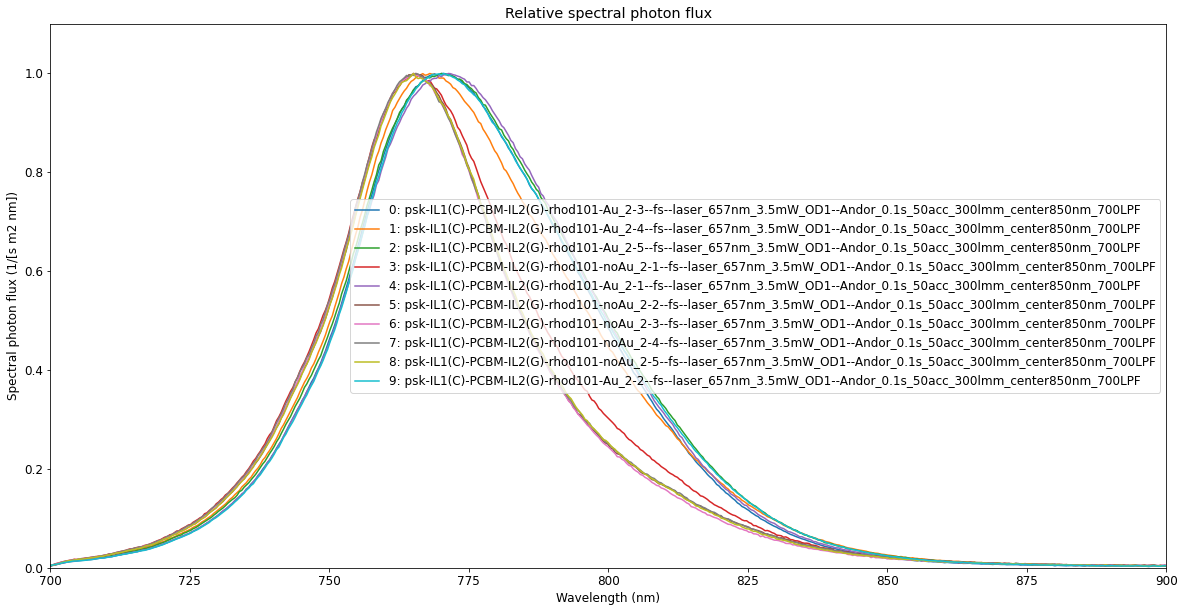

In [26]:
#Plot all data normalized within [left, right]
do_this = True
if do_this:
    left = 700
    right = 900

    spa_norm = PLspectra_nm.copy()
    spa_norm.names_to_label()
    for idx, sp in enumerate(spa_norm):
        if 'fs' in sp.name.split('--')[1]:
            sp.normalize(x_lim = [left, right])

    spa_norm.plot(yscale='linear',
                  left=left,
                  right=right,
                  bottom=0,
                  title='Relative spectral photon flux',
                  showindex=True,
                  figsize=(20, 10),
                  in_name=['fs'])

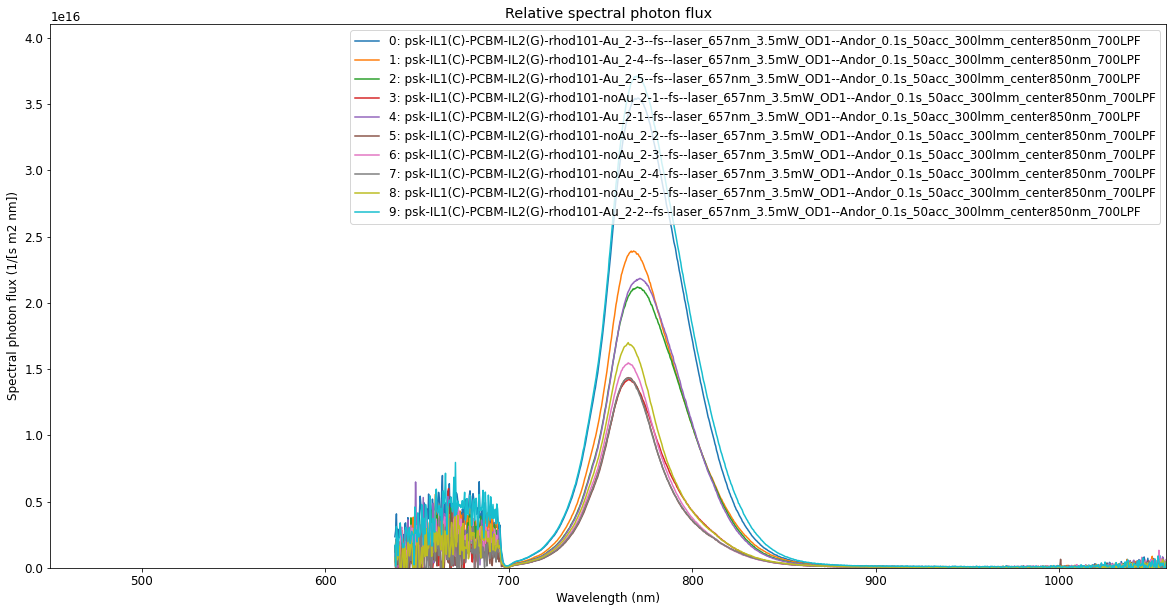

In [20]:
PLspectra_nm.plot(yscale='linear',
                  left=450,
                  bottom=0,
                  title='Relative spectral photon flux',
                  showindex=True,
                  figsize=(20, 10),
                  in_name=['fs'])

In [20]:
# Save all data in exchange folder

if False:
    exch_dir = os.path.join(db.root, 'exchange')

    try:
        os.makedirs(exch_dir, exist_ok = True)
    except OSError as error:
        print("Directory '%s' can not be created" % exch_dir)

    import shutil

    # PL spectra
    samples = db.find_assets({'type': 'calibrated PL spectrum'})
    for idx, sample in enumerate(samples):
        src = sample.file
        FN = os.path.basename(sample.file)
        dst =  os.path.join(exch_dir, FN)
        shutil.copyfile(src, dst)